In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
import pandas as pd
import ants
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy

In [4]:
df = pd.read_csv('../Data/ABIDE_df.csv')
df = df.iloc[~pd.isna(df['bids_folder'].values)]

In [5]:
fn_temp = '../../data/ABIDE/Derivatives/cpac_nofilt_global/{sub}/ses-1/func/{sub}_ses-1_preproc.nii.gz'

In [6]:
subs = df['bids_folder'].values
has_nii = np.array([os.path.exists(fn_temp.format(sub=sub)) for sub in subs])
print(has_nii.mean())

1.0


In [7]:
epi_rois = ants.image_read('../Data/YeoAtlas/epi_rois.nii.gz')
n_rois = np.arange(1,52)
print(len(np.unique(epi_rois.numpy().flatten())))
epi_rois

52


ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (61, 73, 61)
	 Spacing    : (3.0, 3.0, 3.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [7]:
scan_lenghts = []
for sub in tqdm(subs):
    im = ants.image_read(fn_temp.format(sub=sub))
    l = im.spacing[-1]*im.shape[-1]/60
    scan_lenghts.append(l)
    
scan_lenghts = np.array(scan_lenghts)
np.savez(file='../Data/scan_lenghts.npy',arr=scan_lenghts,subs=subs)

100%|██████████| 1102/1102 [30:51<00:00,  1.68s/it]


Text(0.5, 0, 'scan length (min.)')

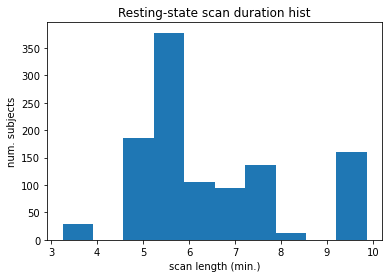

In [8]:
plt.hist(scan_lenghts);
plt.title('Resting-state scan duration hist')
plt.ylabel('num. subjects')
plt.xlabel('scan length (min.)')

In [9]:
def func_get_cmat(mat,roi_arr):
    #roi_arr = epi_rois.flatten()
    #mat = epi_arr[:,idx_first_half]
    #mat.shape

    vv = abs(mat.sum(axis=1))
    e = vv>10

    roi_timeseries = np.array([mat[(roi_arr==r)*e,:].mean(axis=0) for r in range(1,52)])

    #assert not any(np.isnan(roi_timeseries.sum(axis=0))), 'nans'
    #assert all(abs(roi_timeseries.sum(axis=0))>1), 'small values'

    cmat = np.corrcoef(roi_timeseries)
    
    return cmat

In [10]:
rel_cmats = np.zeros((len(subs),51,51,2))
rel_cmats.shape

(1102, 51, 51, 2)

In [11]:
for s in tqdm(range(len(subs))):
    sub = subs[s]
    epi = ants.image_read(fn_temp.format(sub=sub))

    nt = epi.shape[-1]
    buffer = 10
    idx_first_half = np.arange(0,int(nt/2-buffer/2))
    idx_second_half = np.arange(int(nt/2+buffer/2),nt)
    roi_arr = epi_rois.flatten()
    epi_arr = epi.numpy().reshape(-1,nt)

    cmat1 = func_get_cmat(epi_arr[:,idx_first_half],roi_arr)
    cmat2 = func_get_cmat(epi_arr[:,idx_second_half],roi_arr)
    
    rel_cmats[s,:,:,0] = cmat1
    rel_cmats[s,:,:,1] = cmat2
    
np.savez(file='../Assets/rel-cmats',arr=rel_cmats,subs=subs)

  9%|▉         | 103/1102 [04:06<17:55,  1.08s/it]<ipython-input-9-b61bef2cac1e>:9: RuntimeWarning:

Mean of empty slice.

/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 1102/1102 [45:41<00:00,  2.49s/it]


In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [18]:
import numpy as np
from helper_funcs import get_triu
rel_cmats = np.load('../Data/rel-cmats.npz')
list(rel_cmats.keys())

['arr', 'subs']

In [14]:
nsubs = rel_cmats['arr'].shape[0]
rel_cmats['arr'].shape

(1102, 51, 51, 2)

In [42]:
from tqdm import tqdm

In [43]:
cmats1 = np.array([get_triu(rel_cmats['arr'][i,:,:,0]) for i in tqdm(range(nsubs))])
cmats2 = np.array([get_triu(rel_cmats['arr'][i,:,:,1]) for i in tqdm(range(nsubs))])

100%|██████████| 1102/1102 [01:05<00:00, 16.72it/s]


In [58]:
cmats = np.array([cmats1,cmats2])
nonan = (np.isnan(cmats).sum(axis=0).sum(axis=1)==0)
cmats = cmats[:,nonan,:]

cmats.shape

(2, 1086, 1275)

In [59]:
cmats.std(axis=0).mean()

0.07680824087569374

In [60]:
cmats.std(axis=1).mean()

0.1960158175271703

In [64]:
cmats[1,:,:].std(axis=0).mean() / cmats.std(axis=0).mean()

2.5682584002301807